In [1]:
"""
clone and install PySDM dependencies in Colab
"""
import os, sys
if 'google.colab' in sys.modules:
    %cd /content
    if not os.path.isdir('PySDM'):
        !git clone --depth 1 https://github.com/atmos-cloud-sim-uj/PySDM.git
        %cd PySDM
    else:
        %cd PySDM
        !git pull
    !pip install -r requirements.txt
    !ldconfig

In [2]:
import os, sys
if 'google.colab' in sys.modules:
    %cd /content/PySDM
else:
    sys.path.insert(0, os.path.join(os.getcwd(), '../..'))

In [3]:
from PySDM_examples.Arabas_et_al_2015_Figs_8_9.settings import Settings
from PySDM_examples.Arabas_et_al_2015_Figs_8_9.simulation import Simulation
from PySDM_examples.Arabas_et_al_2015_Figs_8_9.storage import Storage
from PySDM_examples.Arabas_et_al_2015_Figs_8_9.netcdf_exporter import NetCDFExporter
from PySDM_examples.Arabas_et_al_2015_Figs_8_9.demo_plots import _TimeseriesPlot, _ImagePlot

from PySDM_examples.utils.temporary_file import TemporaryFile
from PySDM_examples.utils.show_plot import show_plot
from PySDM_examples.utils.widgets import display, HTML, FloatProgress
import PySDM.products as PySDM_products
from PySDM.physics import si

import numpy as np
from scipy.io.netcdf import netcdf_file
from matplotlib import pyplot, rcParams
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from scipy.ndimage.filters import uniform_filter1d

/home/slayoo/devel/PySDM/PySDM_examples/Bartman_et_al_2021/../../PySDM/backends/__init__.py:29: UserWarning: CUDA library found but cuInit() failed (error code: 999; message: unknown error)
  warnings.warn(


In [4]:
class ProgBarController:
    def __init__(self, description):
        self.progress = FloatProgress(value=0.0, min=0.0, max=1.0, description=description)
        self.panic = False
        
    def __enter__(self):
        self.set_percent(0)
        display(self.progress)
        
    def __exit__(self, *_):
        pass

    def set_percent(self, value):
        self.progress.value = value

In [5]:
def label(settings):
    lbl = str({k.replace('condensation_', ''):v for k,v in settings.items()})
    return lbl.replace('{','').replace('}','').replace("'",'')

In [6]:
runs = (
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': True, 'condensation_schedule': 'prev_substeps'}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': True, 'condensation_schedule': 'static'}},
#     {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': False, 'condensation_substeps': 2048}},
#     {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': False, 'condensation_substeps': 1024}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': False, 'condensation_substeps':  512}},
#     {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': False, 'condensation_substeps':  256}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': False, 'condensation_substeps':  128}},
#     {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': False, 'condensation_substeps':   64}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': False, 'condensation_substeps':   32}},
#     {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': False, 'condensation_substeps':   16}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': False, 'condensation_substeps':    8}},
#     {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': False, 'condensation_substeps':    4}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': False, 'condensation_substeps':    2}},
#     {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': False, 'condensation_substeps':    1}}
)

In [7]:
for i, run in enumerate(runs):
    settings = Settings()

    products = (
        PySDM_products.PeakSupersaturation(),
        PySDM_products.WallTime(),
        PySDM_products.AerosolSpecificConcentration(radius_threshold=1*si.um)
    )

    settings.n_sd_per_gridbox = 64
    settings.grid = (64, 64)
    settings.dt = 16 * si.s

# TODO !!!
#     settings.mode_1.norm_factor *= 3
#     settings.mode_2.norm_factor *= 3
#     settings.spectrum_per_mass_of_dry_air.norm_factor *= 3
    settings.simulation_time = .05 * settings.spin_up_time
    settings.output_interval = settings.dt
    settings.condensation_rtol_x = 1e-7
    settings.condensation_rtol_thd = 1e-7
    settings.kappa = .8
# TODO !!!
    
    settings.dt_cond_range = (settings.dt/runs[2]['settings']['condensation_substeps'], settings.dt)
    for key, value in run['settings'].items():        
        assert hasattr(settings, key)
        setattr(settings, key, value)
    
    storage = Storage()
    simulation = Simulation(settings, storage)
    simulation.reinit(products)

    simulation.run(ProgBarController(f"run {i+1}/{len(runs)}"))
    exporter = NetCDFExporter(storage, settings, simulation, run['file'].absolute_path)
    exporter.run(ProgBarController('netCDF'))

FloatProgress(value=0.0, description='run 1/7', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 2/7', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 3/7', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 4/7', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 5/7', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 6/7', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 7/7', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

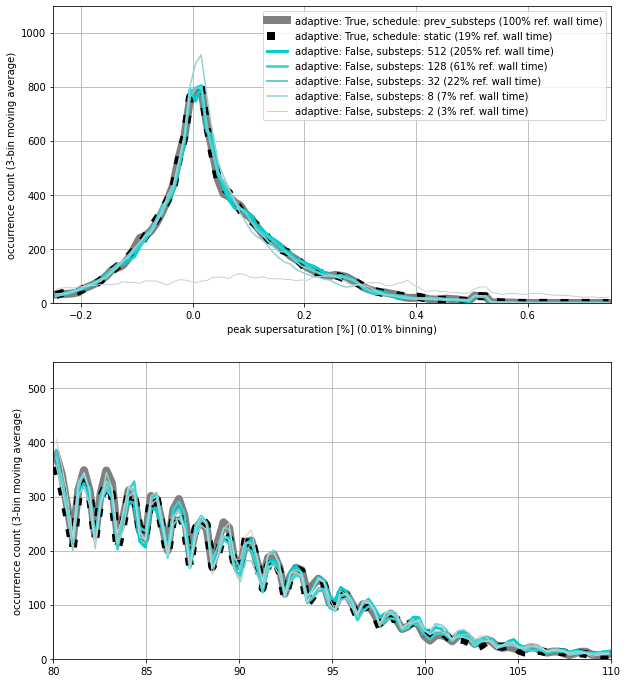

HTML(value="<a href='../utils/temporary_files/tmp6wda9i07.pdf' target='_blank'>../utils/temporary_files/tmp6wd…

In [8]:
from matplotlib import rcParams
rcParams["figure.figsize"] = (10,12)

colors = ('gray', 'black', '#00d0d0', '#33d0d0', '#66d0d0', '#99d0d0', '#CCd0d0', '#FFd0d0')
skip_steps = 1
bins = 100
bin_range = {
    'S_max': (-.25, 0.75),
    'n_a_mg': (80, 110)
}
window = 3

fig, axs = pyplot.subplots(2,1)
for plot_i, var in enumerate(bin_range.keys()):
    ax = axs[plot_i]
    wall_time_ref = None
    for i, run in enumerate(runs):
        nc = netcdf_file(run['file'].absolute_path, mode='r', mmap=False)
        n_spinup = nc.n_spin_up // nc.steps_per_output_interval
        data = nc.variables[var]
        timesteps = slice(skip_steps, -1)
        wall_time = np.mean(nc.variables['wall_time'][timesteps])
        if wall_time_ref is None:
            wall_time_ref = wall_time
        wall_time_ratio = int(wall_time / wall_time_ref * 100)
        y, x, _ = ax.hist(data[timesteps, :, :].flatten(), 
                              bins=bins, range=bin_range[var], histtype='step', 
                              color=colors[i], lw=0)
        ax.plot((x[1:] + x[:-1])/2, uniform_filter1d(y, size=window), color=colors[i], 
                    lw=8 if run['settings']['condensation_adaptive'] else .5+(len(runs)-i)*.5,
                    ls=':' if i == 1 else '-',
                    label=f"{label(run['settings'])} ({wall_time_ratio}% ref. wall time)")
        ax.set_ylabel(f'occurrence count ({window}-bin moving average)')
        if var == 'S_max':
            ax.set_xlabel(f'peak supersaturation [%] ({(bin_range[var][1]-bin_range[var][0])/bins}% binning)')
        elif var == 'n_a_mg':
            pass
        else:
            assert False
    ax.grid()
    if plot_i == 0:
        axs[plot_i].legend()
#     pyplot.ylim(0,2000)
    axs[plot_i].set_xlim(bin_range[var])
show_plot()

In [9]:
# TODO: polluted vs. pristine; N act plots - w sumie 4 sykresy
# TODO: assert if n_threads > 1 static wolniescze od prev_subs
# TODO: print n_threads